# Chapter 4: Geocentric Models - Samples

In [1]:
from scipy import stats
from matplotlib import pyplot as plt
import pathlib
import pandas as pd
import numpy as np
import arviz as az
from scipy.interpolate import griddata
import pymc as pm
from patsy import dmatrix

### Code 4.1

**Normal by Addition**

Thousand people line up on the halfway line of a soccer field. Each has a coin. They begin flipping coins and each time it comes heads, that person moves one step toward the left-hand goal. Each time a coin comes up tails, that person moves one step towards the right-hand goal. Each person flips the coin 16 times, follows the implied moves, and stands still. Now we measure the distance of each person from the halfway line.

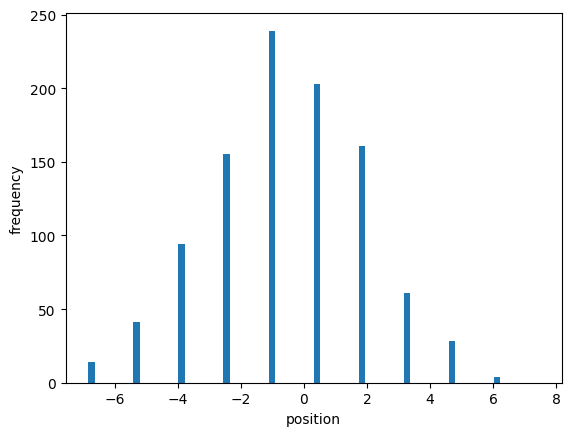

In [2]:
pos = stats.uniform.rvs(size=(16, 1000), loc=-1, scale=2).sum(0)
plt.hist(pos, width=0.2)
plt.ylabel('frequency')
plt.xlabel('position');

### Code 4.2

**Normal by Multiplication**

Suppose a growth rate of an organism is influenced by a dozen loci, each with several alleles that code for mode growth. Suppose also that all of these loci interact with one another, such that each increase growth by a percentage.

In [3]:
stats.uniform.rvs(size=12, loc=1, scale=0.1)

array([1.0298571 , 1.09708253, 1.06563132, 1.00467152, 1.05857416,
       1.01788197, 1.06179977, 1.04127045, 1.06642896, 1.07759125,
       1.06337898, 1.02188928])

### Code 4.3

Text(0, 0.5, 'Density')

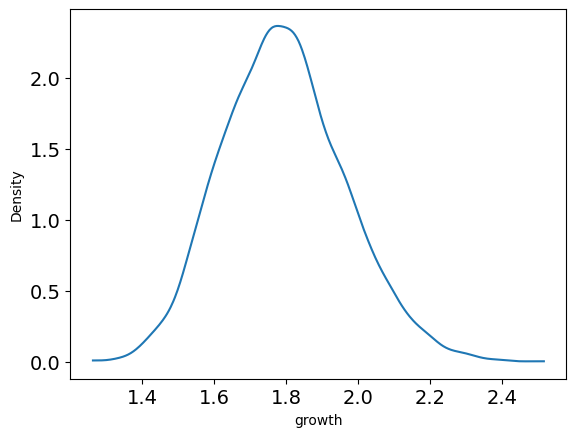

In [4]:
growth = np.prod(stats.uniform.rvs(size=(12, 10_000), loc=1, scale=0.1), axis=0)
az.plot_kde(growth)
plt.xlabel('growth')
plt.ylabel('Density')

### Code 4.4

The smaller the effect of each locus, the better the additive approximation will be. In this way, small effects that multiply together are approximately additive, and so they also tend to stabilize on Gaussian distributions.

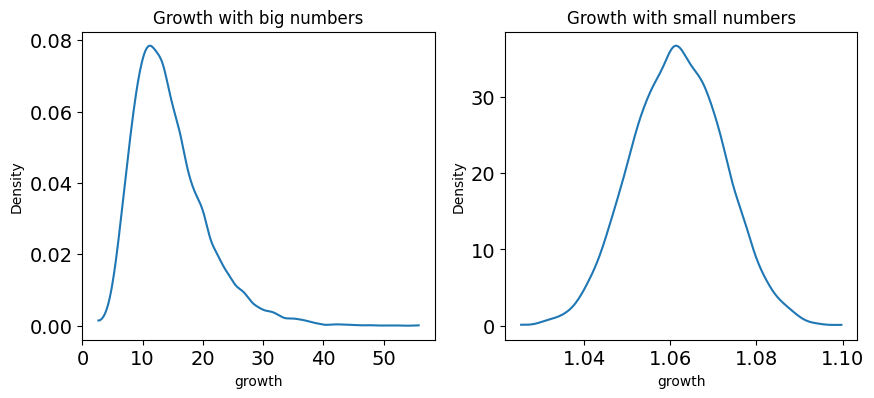

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

big = np.prod(stats.uniform.rvs(size=(12, 10_000), loc=1, scale=0.5), axis=0)
az.plot_kde(big, ax=axs[0])
axs[0].set_title('Growth with big numbers')
axs[0].set_xlabel('growth')
axs[0].set_ylabel('Density')

small = np.prod(stats.uniform.rvs(size=(12, 10_000), loc=1, scale=0.01), axis=0)
az.plot_kde(small, ax=axs[1])
axs[1].set_title('Growth with small numbers')
axs[1].set_xlabel('growth')
axs[1].set_ylabel('Density')

plt.show();

### Code 4.5

**Normal by log-multiplication**

Large deviates that are multiplied together do not produce Gaussian distributions, but they do tend to produce Gaussian distributions on the log scale.

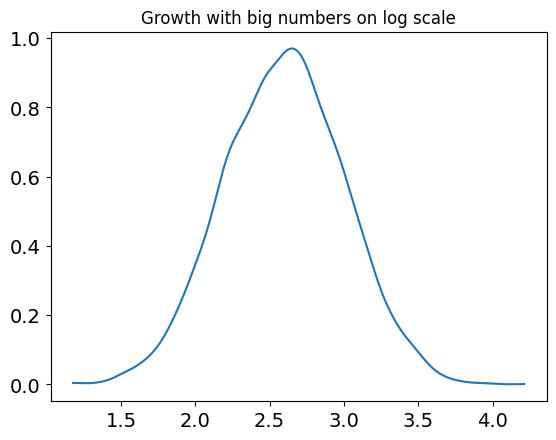

In [6]:
log_big = np.log(np.prod(stats.uniform.rvs(size=(12, 10_000), loc=1, scale=0.5), axis=0))
az.plot_kde(log_big)
plt.title('Growth with big numbers on log scale');

### Code 4.6

$$W \sim \text{Binomial}(N, p)$$

$$p \sim \text{Uniform}(0,1)$$

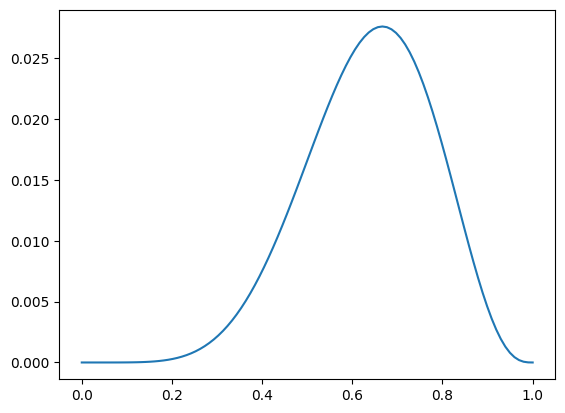

In [7]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=9, p=p_grid) * stats.uniform.pdf(p_grid, loc=0, scale=1)
posterior = posterior / posterior.sum()

plt.plot(p_grid, posterior);

### Code 4.7

Read partial census data for the Dobe area !Kung San.

In [8]:
DATA_PATH = pathlib.Path('..') / '..' / 'data'

d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.8

In [9]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


### Code 4.9

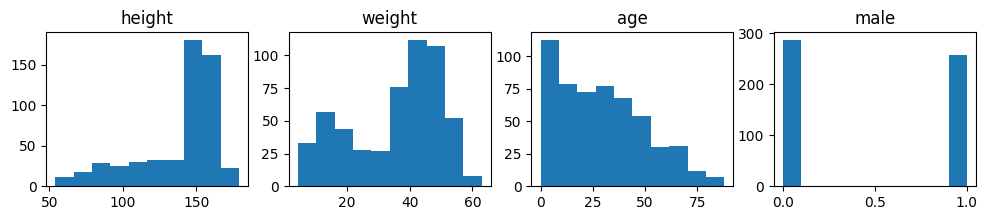

,mean,sd,hdi_3%,hdi_97%
height,138.264,27.602,81.585,172.999
weight,35.611,14.719,7.201,55.282
age,29.344,20.747,0.000,65.300
male,0.472,0.500,0.000,1.000


In [10]:
plt.figure(figsize=(12,2))
for i, column in enumerate(d.columns, 1):
    plt.subplot(1,4,i)
    plt.hist(d[column])
    plt.title(column)
plt.show();
az.summary(d.to_dict(orient="list"), kind="stats")

### Code 4.10

Access one vector.

In [11]:
d['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11

Filter the dataframe down to individuals of age 18 or greater.

In [12]:
d2 = d[d['age'] >= 18]

### Code 4.12

It's a very good idea to plot your priors, so you have a sense of the assumption they build into the model.

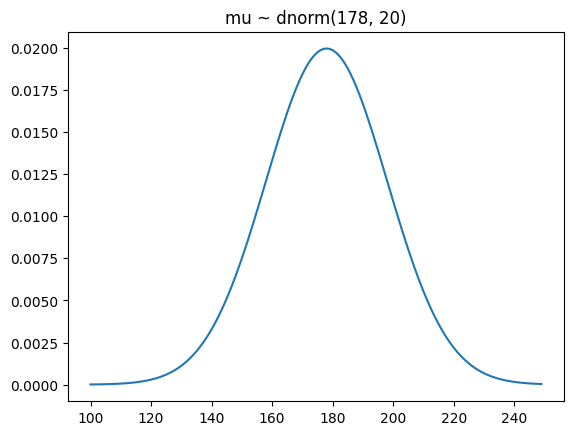

In [13]:
p_grid = np.arange(100, 250)
curve = stats.norm.pdf(p_grid, loc=178, scale=20)
plt.plot(p_grid, curve)
plt.title('mu ~ dnorm(178, 20)');

### Code 4.13

We can also do the same for the $\sigma$ prior.

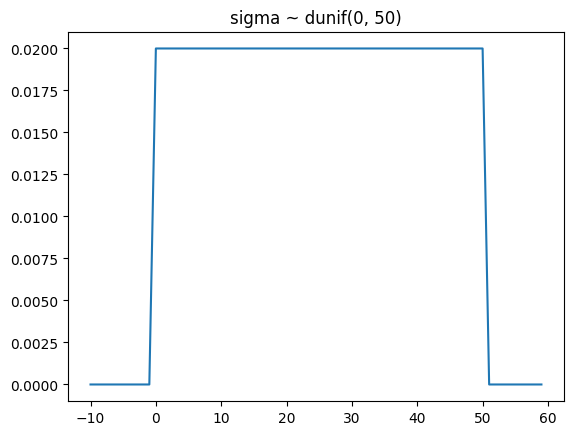

In [14]:
p_grid = np.arange(-10, 60)
curve = stats.uniform.pdf(p_grid, loc=0, scale=50)
plt.plot(p_grid, curve)
plt.title('sigma ~ dunif(0, 50)');

### Code 4.14

**Prior Predictive Simulation** is an essential part of modeling. Once we have priors, these imply a joint prior distribution of individual heights. By simulating from this distribution, you can see what your choices imply about observable height.

Quickly simulate heights by sampling from the prior.

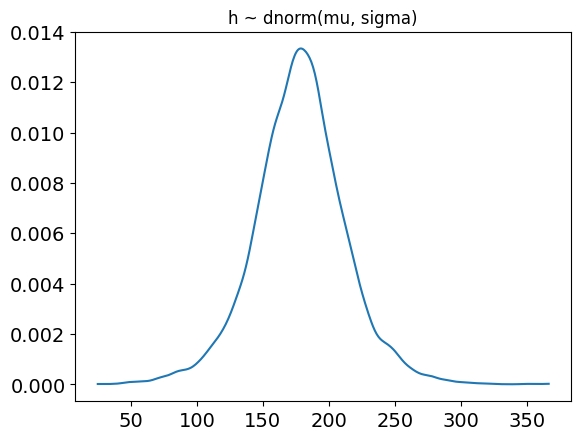

In [15]:
sample_mu = stats.norm.rvs(loc=178, scale=20, size=10_000)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=10_000)
prior_h = stats.norm.rvs(size=10_000, loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.title('h ~ dnorm(mu, sigma)');

### Code 4.15

Consider now a less informative and flatter prior for $\mu$.

$$\mu \sim \text{Normal}(178, 100)$$

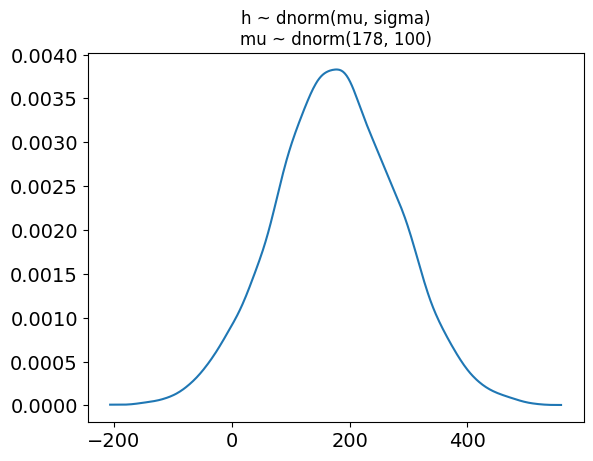

In [16]:
sample_mu = stats.norm.rvs(size=10_000, loc=178, scale=100)
prior_h = stats.norm.rvs(size=10_000, loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.title('h ~ dnorm(mu, sigma)\nmu ~ dnorm(178, 100)');

### Code 4.16

Grid approximation of the posterior distribution.

In [17]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T
post_LL = [stats.norm.logpdf(d2['height'], loc=row[0], scale=row[1]).sum() for row in post]

post_prod = (
    post_LL
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20) 
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - post_prod.max())

### Code 4.17

Get a simple contour plot.

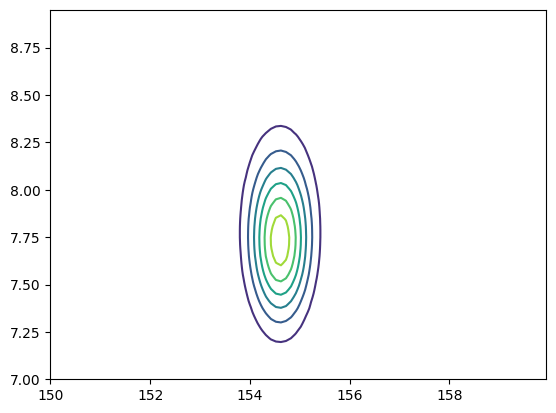

In [18]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata(
    points=(post[:, 0], post[:, 1]),
    values=post_prob, 
    xi=(xi[None, :], yi[:, None])
)

plt.contour(xi, yi, zi);

### Code 4.18

Plot a simple heat map.

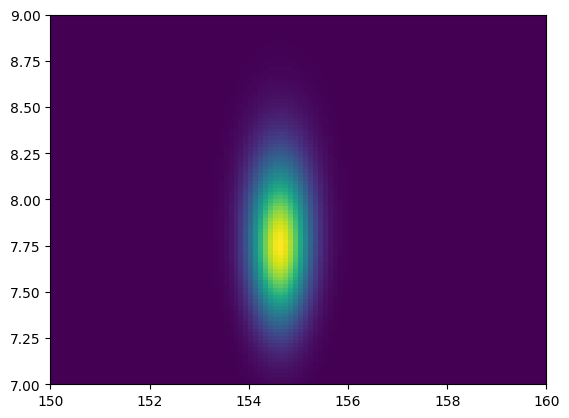

In [19]:
plt.imshow(zi, origin="lower", extent=[150.0, 160.0, 7.0, 9.0], aspect="auto");

### Code 4.19

**Sampling from the posterior**

Study the posterior by sampling from it. Since we have two parameters, we want to sample combinations of them.

In [20]:
post_prob = post_prob / post_prob.sum()
sample_rows = np.random.choice(
    np.arange(len(post)), size=10_000, replace=True, p=post_prob
)
sample_mu = post[sample_rows, 0]
sample_sigma = post[sample_rows, 1]

### Code 4.20

Samples for the posterior distribution for the heights data.

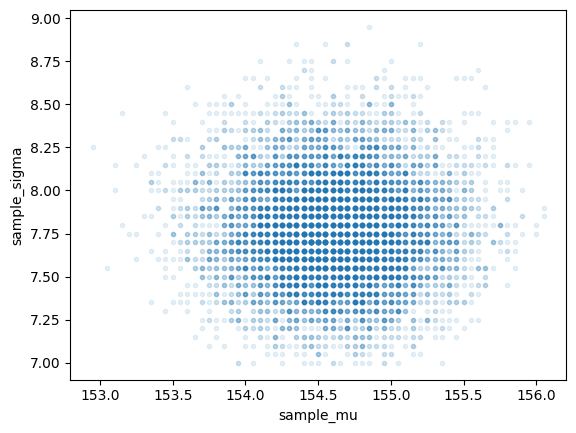

In [21]:
plt.plot(sample_mu, sample_sigma, '.', alpha=0.1)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

### Code 4.21

<AxesSubplot:>

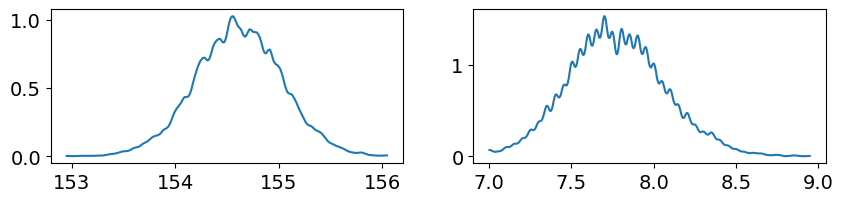

In [22]:
plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
az.plot_kde(sample_mu)
plt.subplot(1, 2, 2)
az.plot_kde(sample_sigma)

### Code 4.22

In [23]:
print(np.quantile(sample_mu, [0.05, 0.95]))
print(np.quantile(sample_sigma, [0.05, 0.95]))

[153.9 155.3]
[7.3  8.25]


### Code 4.23

Analyse only 20 of the heights from the height data to reveal this issue.

In [24]:
d3 = np.random.choice(d2['height'], size=20)

### Code 4.24

Repeat all the code from the previous subsection, modified to focus on the 20 heights in `d3`.

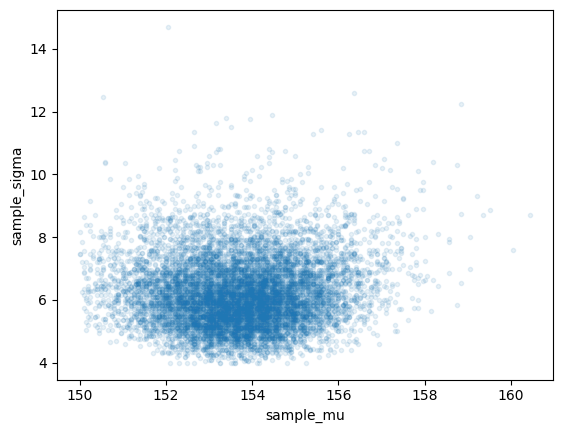

In [25]:
post2 = np.mgrid[150:170:0.05, 4:20:0.05].reshape(2, -1).T
post2_LL = [stats.norm.logpdf(d3, loc=row[0], scale=row[1]).sum() for row in post2]

post2_prod = (
    post2_LL
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20) 
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)
post2_prob = np.exp(post2_prod - post2_prod.max())
post2_prob = post2_prob / post2_prob.sum()
sample2_rows = np.random.choice(
    np.arange(len(post2)), size=10_000, replace=True, p=post2_prob
)
sample2_mu = post2[sample2_rows, 0]
sample2_sigma = post2[sample2_rows, 1]
plt.plot(sample2_mu, sample2_sigma, '.', alpha=0.1)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

### Code 4.25

Inspect the marginal posterior density for $\sigma$, averaging over $\mu$.

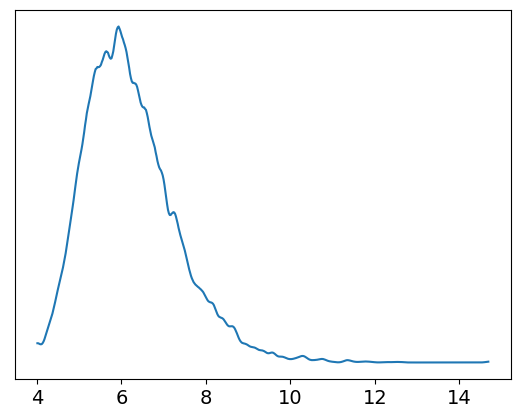

In [26]:
az.plot_kde(sample2_sigma);
plt.yticks([]);

### Code 4.26

**Finding the posterior distribution with `quap`**

In [27]:
d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')
d2 = d[d['age'] >= 18]

### Code 4.27

Place the model definition in a variable.

In [28]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2['height'].values)

### Code 4.28

Fit the model to the data in the dataframe `d2`.

In [29]:
mean_q = pm.find_MAP(model=m4_1)
H = pm.find_hessian(mean_q, model=m4_1)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [mu, sigma]])
posterior = stats.multivariate_normal(mean=mean, cov=cov)

### Code 4.29

Take a look at the posterior distribution.

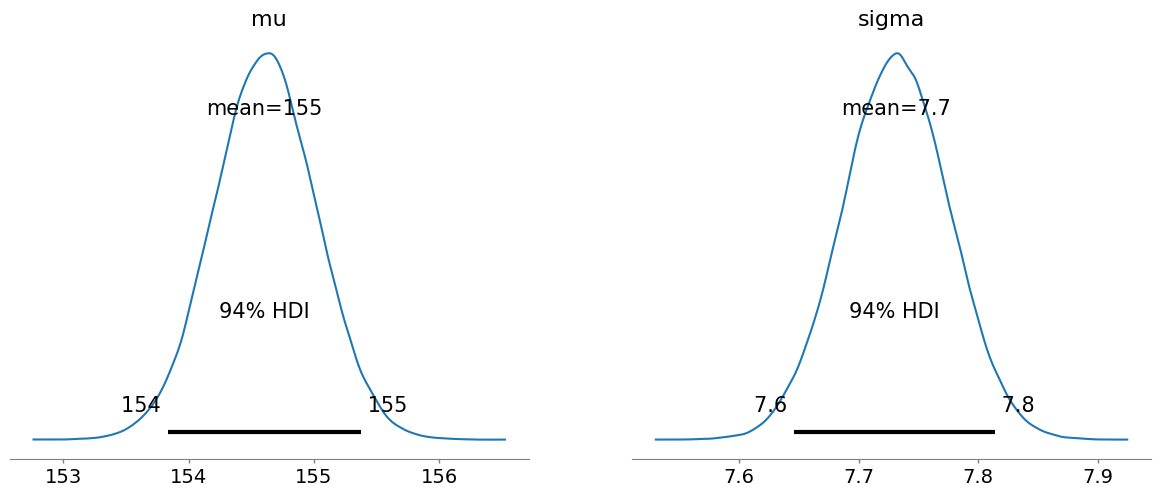

In [30]:
samples = {}
samples_out = posterior.rvs(size=100_000)
samples['mu'] = samples_out[:, 0]
samples['sigma'] = samples_out[:, 1]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

### Code 4.30

Can't pass initial starting point to `minimize` of `find_MAP`.

### Code 4.31

Narrow the `mu` prior.

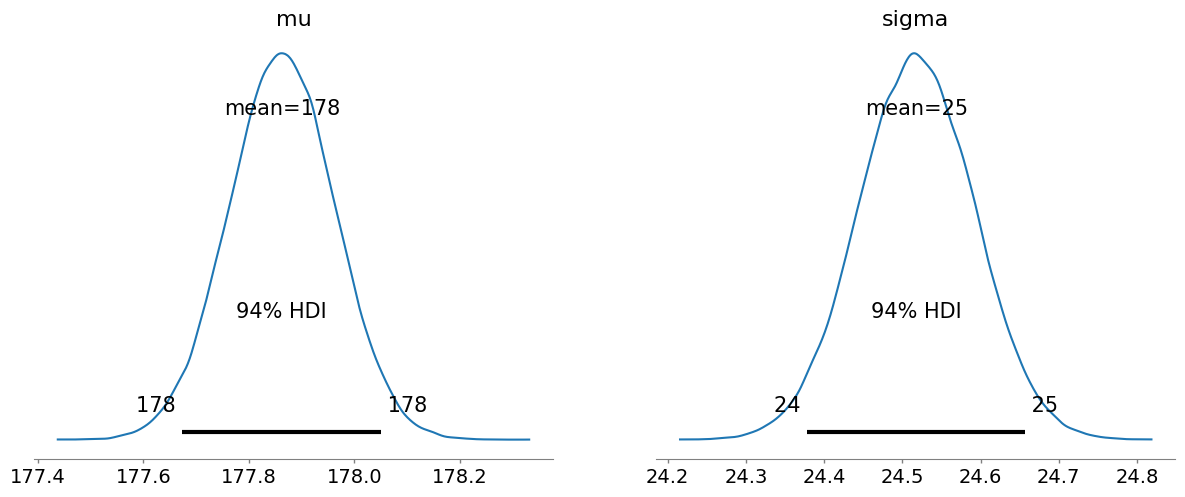

In [31]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2['height'].values)
    
mean_q = pm.find_MAP(model=m4_2)
H = pm.find_hessian(mean_q, model=m4_2)
cov2 = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [mu, sigma]])
posterior2 = stats.multivariate_normal(mean=mean, cov=cov2)

samples_out = posterior2.rvs(size=100_000)
samples['mu'] = samples_out[:, 0]
samples['sigma'] = samples_out[:, 1]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

### Code 4.32

Get the covariances.

In [32]:
cov

array([[1.69739610e-01, 3.33420146e-05],
       [3.33420146e-05, 1.98658001e-03]])

### Code 4.33

Factor covariance into vector of variances for the parameters, and into a correlation matrix that tells us how changes in any parameters lead to correlated changes in the others.

In [33]:
np.diag(cov)

array([0.16973961, 0.00198658])

In [34]:
v = np.sqrt(np.diag(cov))
outer_v = np.outer(v, v)
corr = cov / outer_v
corr[cov == 0] = 0
corr

array([[1.        , 0.00181571],
       [0.00181571, 1.        ]])

### Code 4.34

Sample vectors of values from a multi-dimensional Gaussian distribution.

In [35]:
post = posterior.rvs(size=10_000)
post = pd.DataFrame(post, columns=['mu', 'sigma'])
post.head()

,mu,sigma
0,154.330578,7.688836
1,154.645329,7.796326
2,154.504953,7.680835
3,155.284971,7.685503
4,154.562410,7.803222


### Code 4.35

Each value is a sample from the posterior, so the mean and standard deviation of each column will be very close to the MAP values from before.

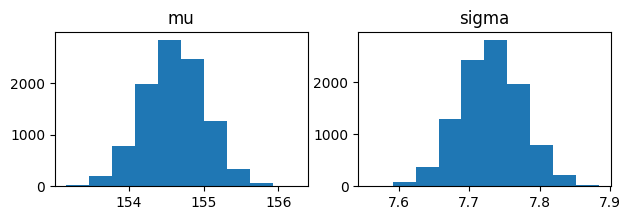

,mean,sd,hdi_3%,hdi_97%
mu,154.609,0.412,153.840,155.377
sigma,7.731,0.044,7.645,7.812


In [36]:
plt.figure(figsize=(15,2))
for i, column in enumerate(post.columns, 1):
    plt.subplot(1,4,i)
    plt.hist(post[column])
    plt.title(column)
plt.show();
az.summary(post.to_dict(orient="list"), kind="stats")

### Code 4.36

Create a multivariate normal distribution.

In [37]:
post = stats.multivariate_normal.rvs(mean=posterior.mean, cov=posterior.cov, size=10_000)

### Code 4.37

Plot adult height and weight against one another

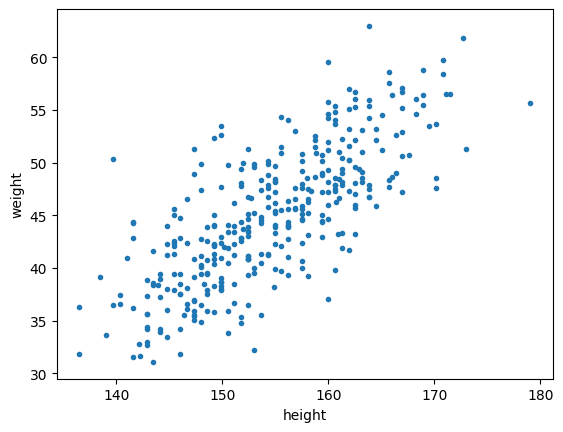

In [38]:
plt.plot(d2['height'], d2['weight'], '.')
plt.xlabel('height')
plt.ylabel('weight');

### Code 4.28

Simulate a bunch of lines implied by priors of $\alpha$ and $\beta$

In [39]:
np.random.seed(2971)
N = 100
a = np.random.normal(size=N, loc=178, scale=20)
b = np.random.normal(size=N, loc=0, scale=10)

### Code 4.39

Plot lines for the 100 pairs of parameters.

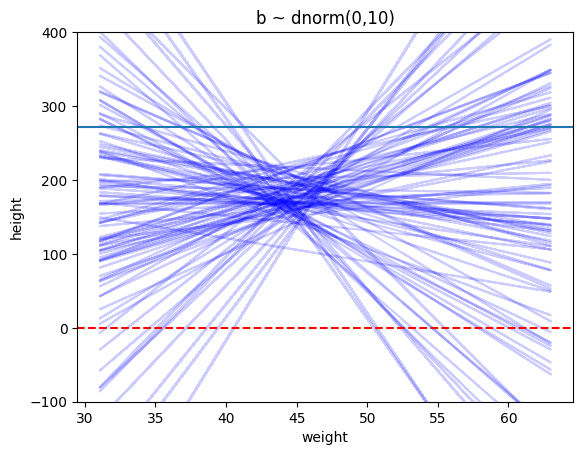

In [40]:
xbar = d2['weight'].mean()
for i in range(N):
    plt.plot(d2['weight'], a[i] + b[i] * (d2['weight'] - xbar), 'b', alpha=0.2)
plt.ylim([-100, 400])
plt.axhline(0, color='r', linestyle='--')
plt.axhline(272)
plt.title('b ~ dnorm(0,10)')
plt.xlabel('weight')
plt.ylabel('height');

### Code 4.40

Use Log-Normal instead for $\beta$.

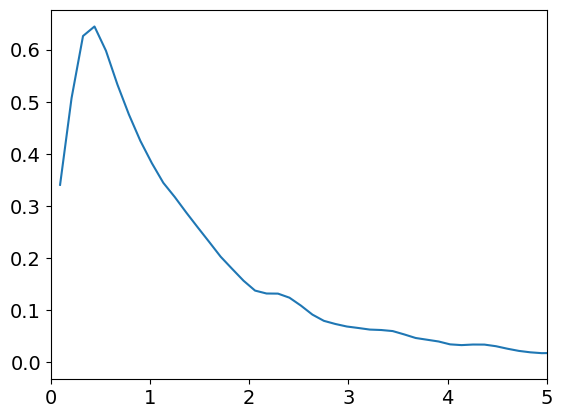

In [41]:
b = np.random.lognormal(size=10_000, mean=0, sigma=1)
az.plot_kde(b)
plt.xlim([0,5]);

### Code 4.41

Do the prior predictive simulation again.

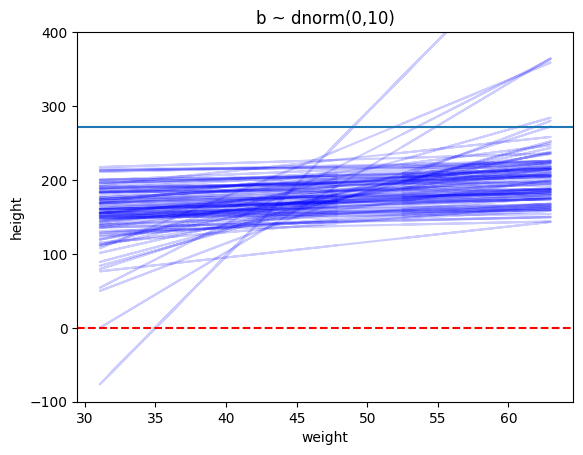

In [42]:
b = np.random.lognormal(size=100, mean=0, sigma=1)
for i in range(N):
    plt.plot(d2['weight'], a[i] + b[i] * (d2['weight'] - xbar), 'b', alpha=0.2)
plt.ylim([-100, 400])
plt.axhline(0, color='r', linestyle='--')
plt.axhline(272)
plt.title('b ~ dnorm(0,10)')
plt.xlabel('weight')
plt.ylabel('height');

### Code 4.42

Build the posterior approximation.

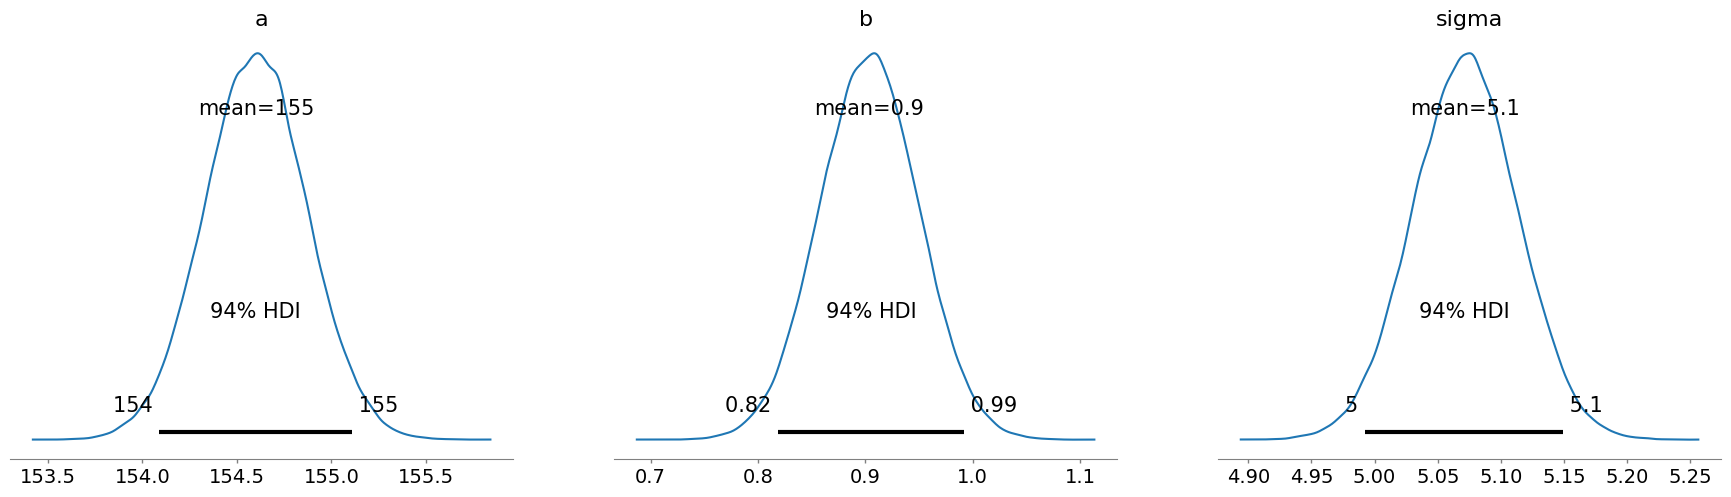

In [43]:
d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')
d2 = d[d['age'] >= 18]

# define the average weight, x-bar
xbar = d2['weight'].mean()

# fit model
with pm.Model() as m4_3:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a + b*(d2['weight'] - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'].values)
    
mean_q = pm.find_MAP(model=m4_3)
H = pm.find_hessian(mean_q, model=m4_3)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior4_3 = stats.multivariate_normal(mean=mean, cov=cov)

samples = {}

samples_out = posterior4_3.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b'] = samples_out[:, 1]
samples['sigma'] = samples_out[:, 2]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

### Code 4.43

Same thing as above, but exponentiating a normal distribution (equal to above).

In [44]:
with pm.Model() as m4_3b:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.Normal('b', mu=0, sigma=10)
    mu = a + np.exp(b) * (d2['weight'].values - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'].values)
    
mean_q = pm.find_MAP(model=m4_3b)
H = pm.find_hessian(mean_q, model=m4_3b)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posterior4_3b = stats.multivariate_normal(mean=mean, cov=cov)

### Code 4.44

Inspect the marginal posterior distributions of the parameters.

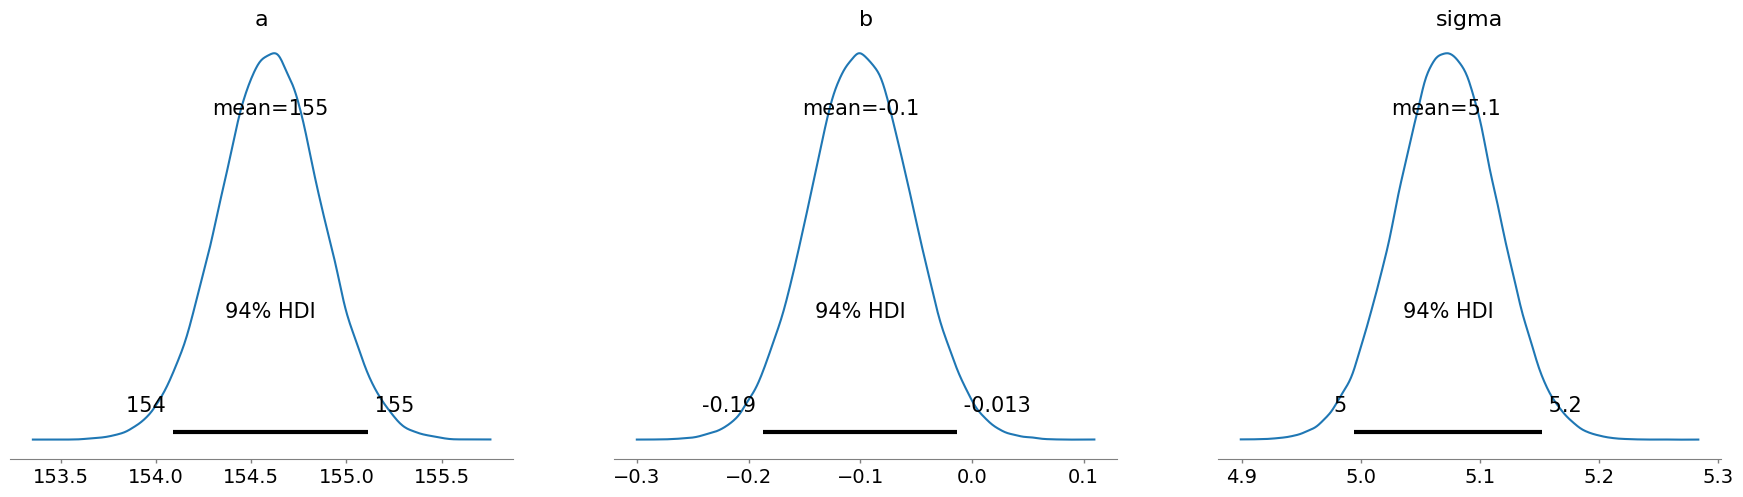

In [45]:
samples = {}

samples_out = posterior4_3b.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b'] = samples_out[:, 1]
samples['sigma'] = samples_out[:, 2]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

### Code 4.45

Check the covariances among the parameters.

In [46]:
cov.round(4)

array([[ 0.0731, -0.    ,  0.    ],
       [-0.    ,  0.0021, -0.    ],
       [ 0.    , -0.    ,  0.0018]])

### Code 4.46

Plot the raw data and compute the mean values for a and b.

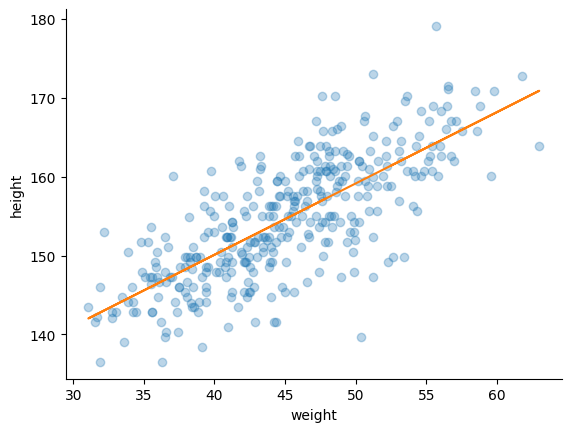

In [47]:
fig, ax = plt.subplots()
plt.plot(d2['weight'], d2['height'], 'o', alpha=0.3)
post = posterior4_3.rvs(size=100_000)
a_map = post[:, 0].mean()
b_map = post[:, 1].mean()
plt.plot(d2['weight'], a_map + b_map*(d2['weight'] - xbar))
plt.xlabel('weight')
plt.ylabel('height')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

### Code 4.47

To better appreciate how the posterior distribution contains lines, we work with all of the samples in the model. Let's take a closer look at the samples below.

In [48]:
post

array([[154.67020166,   0.93889345,   5.13852699],
       [155.05381889,   0.90023963,   5.02238165],
       [154.8422071 ,   0.87263002,   5.0973072 ],
       ...,
       [154.27637658,   0.87954827,   4.97542613],
       [154.67598867,   0.93004187,   5.0583591 ],
       [154.40726303,   0.92020534,   5.11370727]])

### Code 4.48

Re-estimate the model with first 10 cases.

In [49]:
N = 10
dN = d2.iloc[:N, :]

with pm.Model() as mN:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.LogNormal('b', mu=0, sigma=1)
    mu = a + b * (dN['weight'].values - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=dN['height'].values)
    
mean_q = pm.find_MAP(model=mN)
H = pm.find_hessian(mean_q, model=mN)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b, sigma]])
posteriormN = stats.multivariate_normal(mean=mean, cov=cov)

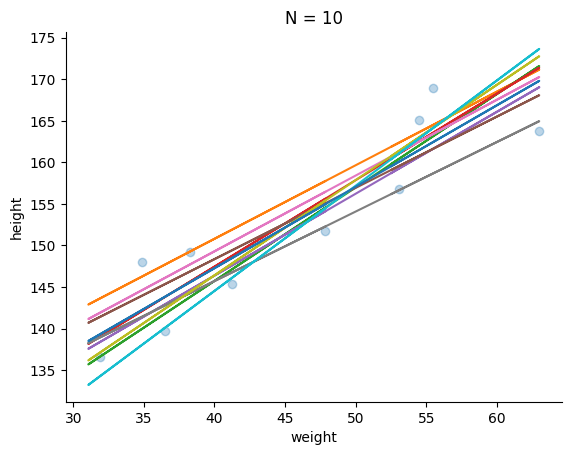

In [50]:
# extract 20 samples from the posterior
post = posteriormN.rvs(size=N)

# display raw data and sample size
fig, ax = plt.subplots()
plt.plot(dN['weight'], dN['height'], 'o', alpha=0.3)
plt.title('N = 10')
a = post[:, 0]
b = post[:, 1]
for i in range(N):
    plt.plot(d2['weight'], a[i] + b[i]*(d2['weight'] - xbar))
plt.xlabel('weight')
plt.ylabel('height')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

### Code 4.50

Quickly make 10,000 values of $\mu$ for an invididual who weight 50 kilograms.

In [51]:
post = posterior4_3.rvs(size=10_000)
mu_at_50 = post[:, 0] + post[:, 1] * (50 - xbar)

### Code 4.51

Plot the density of this vector.

Text(0.5, 0, 'mu|weight=50')

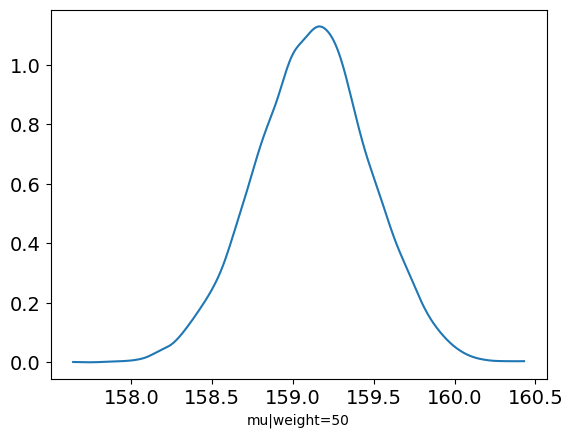

In [52]:
az.plot_kde(mu_at_50)
plt.xlabel('mu|weight=50')

### Code 4.52

Find the 89% compatibility interval for $\mu$ at 50 kg.

In [53]:
np.quantile(mu_at_50, [0.055, 0.945])

array([158.54654494, 159.69481608])

### Code 4.53 & 4.54

Compute $\mu$ directly

In [54]:
weights = np.arange(25, 71)
weights_seq = np.tile(weights, (10_000, 1))
post = posterior4_3.rvs(size=10_000)
mu = post[:, 0:1] + post[:, 1:2] * (weights - d2['weight'].mean())
mu

array([[136.4572628 , 137.35228563, 138.24730847, ..., 174.94324488,
        175.83826772, 176.73329056],
       [134.67908936, 135.65497174, 136.63085412, ..., 176.64203176,
        177.61791414, 178.59379653],
       [136.60087964, 137.51674606, 138.43261248, ..., 175.98313579,
        176.89900221, 177.81486863],
       ...,
       [135.02656177, 136.02096494, 137.01536811, ..., 177.78589804,
        178.78030121, 179.77470438],
       [135.73755016, 136.68982217, 137.64209418, ..., 176.68524654,
        177.63751855, 178.58979056],
       [136.9429892 , 137.84092252, 138.73885585, ..., 175.55412212,
        176.45205544, 177.34998877]])

### Code 4.55

Plot the distribution of $\mu$ values at each height.

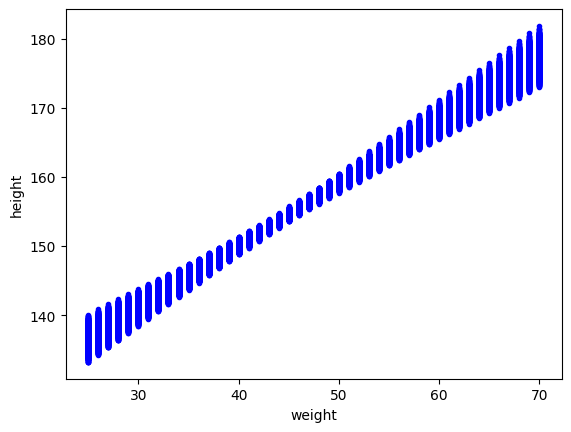

In [55]:
plt.plot(weights, mu.T, 'b.')
plt.xlabel('weight')
plt.ylabel('height');

### Code 4.56

Summarize the distribution of each weight value.

In [56]:
mu_mean = mu.mean(axis=0)
mu_pi = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

### Code 4.57

Plot the results

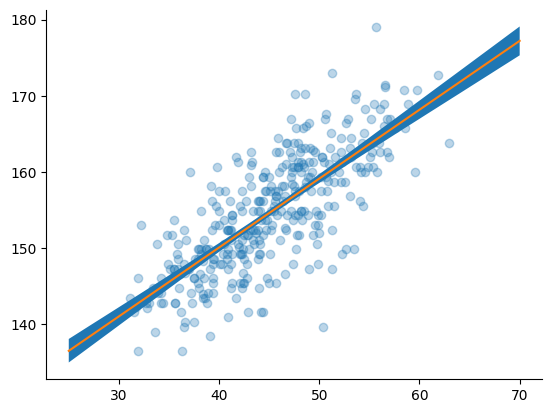

In [57]:
fig, ax = plt.subplots()
plt.plot(d2['weight'], d2['height'], 'o', alpha=0.3)

plt.plot(weights, mu_mean)
plt.fill_between(weights, mu_pi[:, 0], mu_pi[:, 1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

### Code 4.58

Recreate the link function

In [58]:
weights = np.arange(25, 71)

def link(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * (weights_seq - d2['weight'].mean())
    return mu

link(posterior4_3, weights);

### Code 4.59  & 4.62 & 4.63

End up with a collection of simulated heights that embody the uncertainty in the posterior as well as the uncertainty in the Gaussian distribution of heights.

In [59]:
weights = np.arange(25, 71)

def sim(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * (weights_seq - d2['weight'].mean())
    sigmas = np.tile(post[:, 2], (len(seq), 1)).T
    sim = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(seq)))
    return sim

sim_height = sim(posterior4_3, weights)
sim_height

array([[139.77939346, 137.38547836, 139.55475959, ..., 176.79348364,
        179.07921331, 177.50594006],
       [135.89625812, 137.31842833, 143.44575015, ..., 172.47272533,
        177.92129097, 170.86564313],
       [141.36319614, 132.95848852, 143.87260475, ..., 182.32676513,
        170.67629308, 177.09557943],
       ...,
       [126.06249562, 133.92992376, 146.44889534, ..., 179.26336617,
        173.75573304, 168.97634398],
       [132.11990709, 136.35471797, 131.87591389, ..., 176.95165058,
        163.11912783, 183.26443188],
       [133.75854399, 136.23650395, 139.64753971, ..., 172.97863436,
        174.35831075, 178.81689222]])

### Code 4.60

We can summarize the simulated heights in the same way we summarized the distribution of $\mu$.

In [60]:
height_pi = np.array([np.quantile(heights, [0.055, 0.945]) for heights in sim_height.T])

### Code 4.61

Let's plot everything.

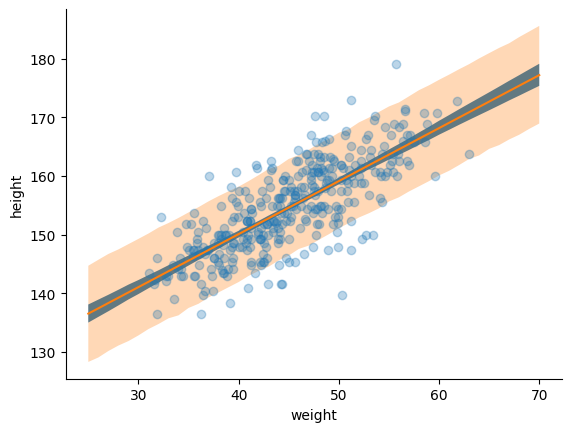

In [61]:
fig, ax = plt.subplots()
plt.plot(d2['weight'], d2['height'], 'o', alpha=0.3)

plt.plot(weights, mu_mean)

mu_hpdi = np.array([az.hdi(m, hdi_prob=0.89) for m in mu.T])
plt.fill_between(weights, mu_hpdi[:, 0], mu_hpdi[:, 1])


plt.fill_between(weights, height_pi[:, 0], height_pi[:, 1], alpha=0.3)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('weight')
plt.ylabel('height');

### Code 4.64

Curves from lines

In [62]:
d = pd.read_csv(DATA_PATH.joinpath('Howell1.csv'), sep=';')

### Code 4.65

$$h_i \sim \text{Normal}(\mu_i, \sigma)$$

$$\mu_i = \alpha + \beta_ix_i + \beta_2x_i^2$$

$$\alpha \sim \text{Normal}(178, 20)$$

$$\beta_1 \sim \text{Log-Normal}(0,1)$$

$$\beta_2 \sim \text{Normal}(0,1)$$

$$\sigma \sim \text{Uniform}(0, 50)$$

In [63]:
d['weight_s'] = (d['weight'] - d['weight'].mean()) / d['weight'].std()
d['weight_s2'] = d['weight_s']**2

with pm.Model() as m_4_5:
    a = pm.Normal('a', mu=178, sigma=100)
    b1 = pm.Lognormal('b1', mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', a + b1 * d['weight_s'].values + b2 * d['weight_s2'].values)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height.values)
    
mean_q = pm.find_MAP(model=m_4_5)
H = pm.find_hessian(mean_q, model=m_4_5)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b1, b2, sigma]])
posterior4_5 = stats.multivariate_normal(mean=mean, cov=cov)

### Code 4.66

Read the relationship.

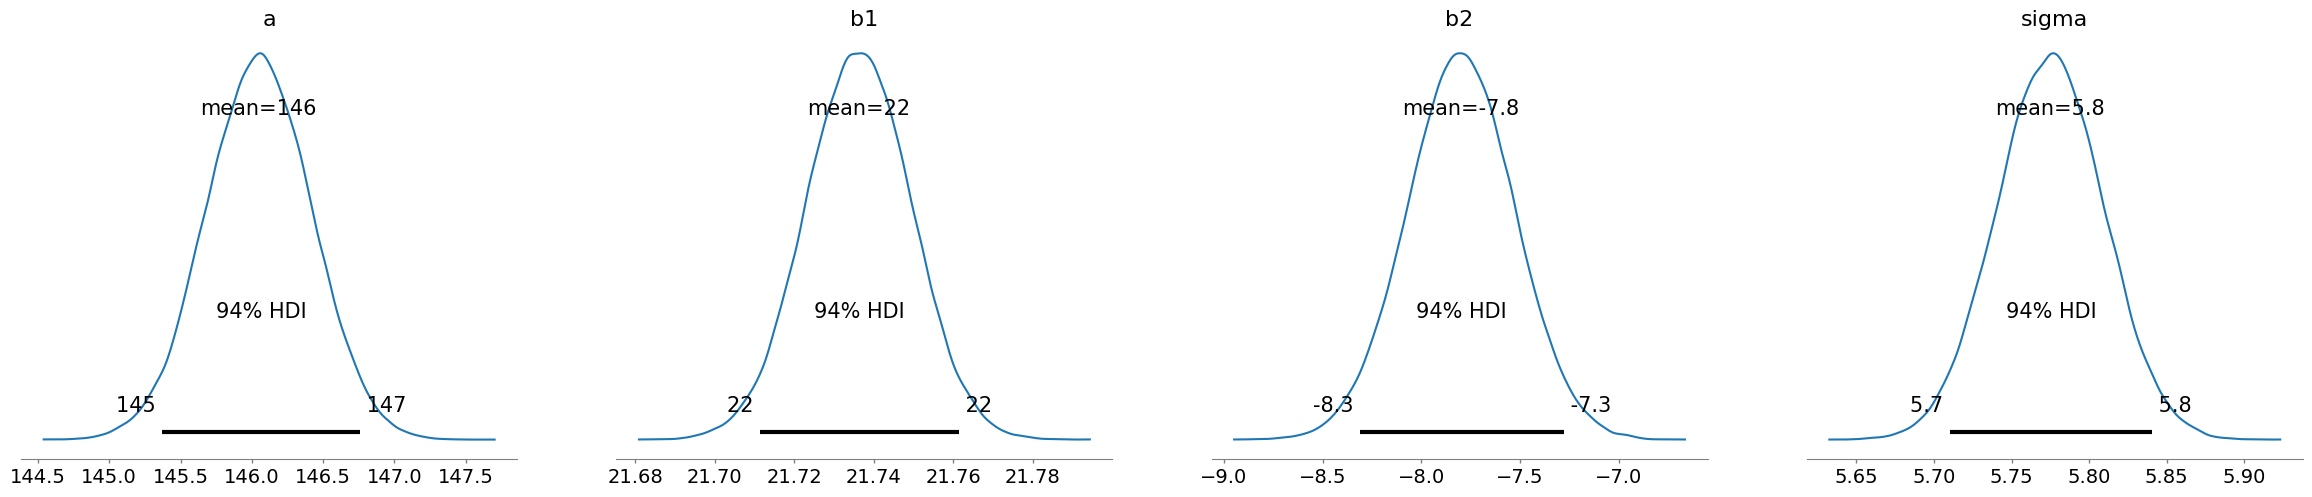

In [64]:
samples = {}

samples_out = posterior4_5.rvs(size=100_000)
samples['a'] = samples_out[:, 0]
samples['b1'] = samples_out[:, 1]
samples['b2'] = samples_out[:, 2]
samples['sigma'] = samples_out[:, 3]
infer_data = az.convert_to_inference_data(samples)
az.plot_posterior(infer_data);

### Code 4.67

Calculate the mean relationship and the 89% intervals.

In [65]:
weights = np.linspace(-2.2, 2, 30)

def link(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * weights_seq + post[:, 2:3] * weights_seq**2
    return mu

mu = link(posterior4_5, weights);
mu_mean = mu.mean(axis=0)
mu_pi = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

def sim(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + post[:, 1:2] * weights_seq + post[:, 2:3] * weights_seq**2
    sigmas = np.tile(post[:, 3], (len(seq), 1)).T
    sim = np.random.normal(loc=mu, scale=sigmas, size=(10000, len(seq)))
    return sim

sim_height = sim(posterior4_5, weights)
height_pi = np.array([np.quantile(heights, [0.055, 0.945]) for heights in sim_height.T])

### Code 4.68

Plot.

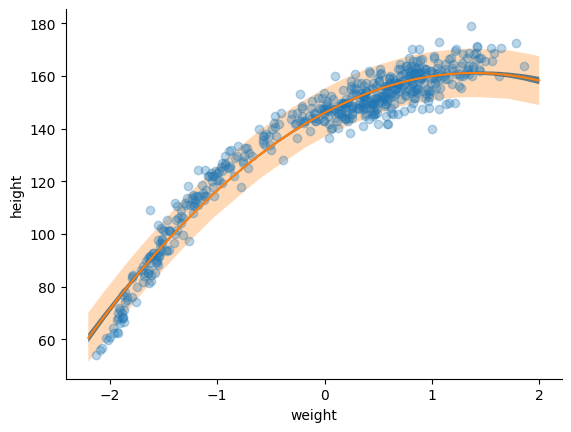

In [66]:
fig, ax = plt.subplots()
plt.plot(d['weight_s'], d['height'], 'o', alpha=0.3)

plt.plot(weights, mu_mean)
plt.fill_between(weights, mu_pi[:, 0], mu_pi[:, 1])
plt.fill_between(weights, height_pi[:, 0], height_pi[:, 1], alpha=0.3)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('weight')
plt.ylabel('height');

### Code 4.69

Fit the model with a slight modification of the parabolic model's code.

$$h_i \sim \text{Normal}(\mu_i, \sigma)$$

$$\mu_i = \alpha + \beta_ix_i + \beta_2x_i^2 + \beta_3x_i^3$$

$$\alpha \sim \text{Normal}(178, 20)$$

$$\beta_1 \sim \text{Log-Normal}(0,1)$$

$$\beta_2 \sim \text{Normal}(0,1)$$

$$\beta_3 \sim \text{Normal}(0,1)$$

$$\sigma \sim \text{Uniform}(0, 50)$$

In [67]:
d['weight_s3'] = d['weight_s']**3

with pm.Model() as m_4_6:
    a = pm.Normal('a', mu=178, sigma=100)
    b1 = pm.Lognormal('b1', mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    b3 = pm.Normal('b3', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic(
        'mu',
        a 
        + b1 * d['weight_s'].values 
        + b2 * d['weight_s2'].values 
        + b3 * d['weight_s3'].values
    )
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height.values)
    
mean_q = pm.find_MAP(model=m_4_6)
H = pm.find_hessian(mean_q, model=m_4_6)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, b1, b2, b3, sigma]])
posterior4_6 = stats.multivariate_normal(mean=mean, cov=cov)

### Code 4.70 & 4.71

Since the weight axis is standardized, we might want to remove the values from the axis.

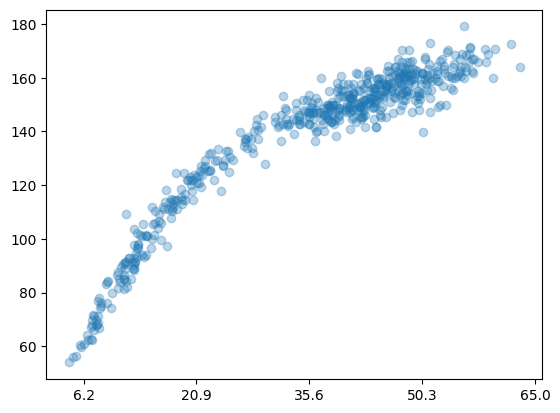

In [68]:
plt.plot(d['weight_s'], d['height'], 'o', alpha=0.3)
# convert x-axis back to original scale
at = np.arange(-2, 3)
labels = np.round(at * d.weight.std() + d.weight.mean(), 1)
plt.xticks(at, labels);

### Code 4.72

Load a thousand years of blossom dates.

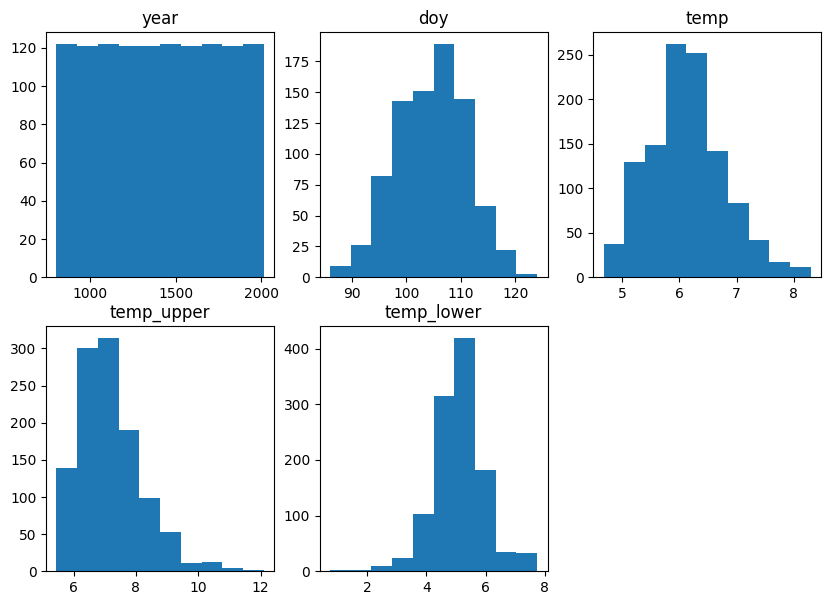

,mean,sd,hdi_3%,hdi_97%
year,1533.395,291.123,1016.00,1978.00
doy,104.921,6.258,92.00,115.00
temp,6.100,0.683,4.80,7.32
temp_upper,6.938,0.812,5.56,8.40
temp_lower,5.264,0.762,3.75,6.83


In [69]:
d = pd.read_csv(DATA_PATH.joinpath('cherry_blossoms.csv'))
plt.figure(figsize=(10,7))
for i, column in enumerate(d.columns, 1):
    plt.subplot(2,3,i)
    plt.hist(d[column])
    plt.title(column)
plt.show();
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

### Code 4.73

Create 15 knots for this dataset.

In [70]:
d2 = d.dropna(subset=['doy'])
num_knots = 15
knot_list = np.quantile(d2['year'], np.linspace(0, 1, num_knots))

### Code 4.74

Create the basis functions for a degree 3 (cubic) spline.

In [71]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": d2['year'].values, "knots": knot_list[1:-1]},
)

### Code 4.75

Display the basis functions.

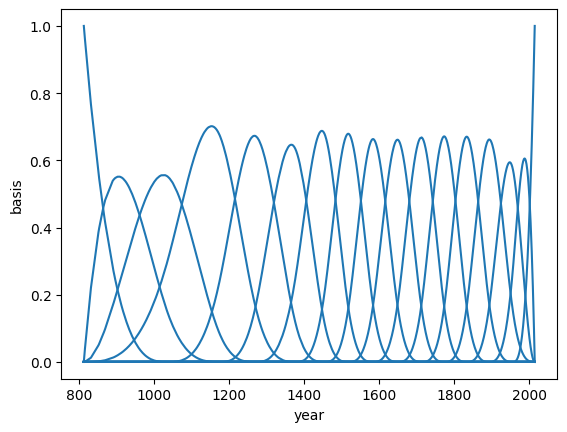

In [72]:
for i in range(B.shape[1]):
    plt.plot(d2['year'], (B[:, i]), color="C0")
plt.xlabel("year")
plt.ylabel("basis");

### Code 4.76

Build the model with basis functions.

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$

$$\mu_i = \alpha + \sum_{k=1}^Kw_kB_{k,i}$$

And then the priors:

$$\alpha \sim \text{Normal}(100, 10)$$

$$w_j \sim \text{Normal}(0,10)$$

$$\sigma \sim \text{Exponential}(1)$$

In [73]:
with pm.Model() as m4_7:
    a = pm.Normal('a', 100, 10)
    w = pm.Normal('w', mu=0, sigma=10, shape=B.shape[1])
    mu = pm.Deterministic('mu', a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential('sigma', 1)
    D = pm.Normal('D', mu, sigma, observed=d2['doy'].values)
    
mean_q = pm.find_MAP(model=m4_7)
H = pm.find_hessian(mean_q, model=m4_7)
cov = np.linalg.inv(H)
mean = np.concatenate([np.atleast_1d(mean_q[v.name]) for v in [a, w, sigma]])
posterior4_7 = stats.multivariate_normal(mean=mean, cov=cov)

### Code 4.77

Plot the posterior predictions.

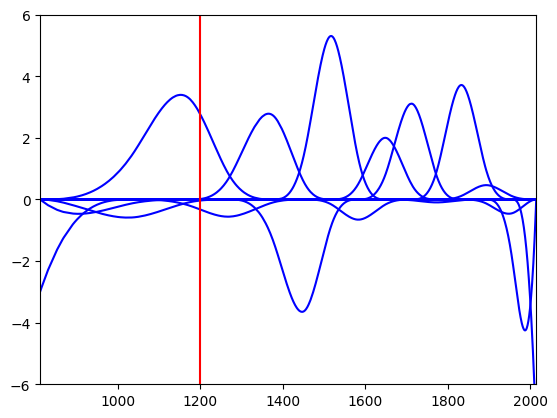

In [74]:
samples = {}

samples_out = posterior4_7.rvs(size=100_000)
w = samples_out.mean(axis=0)[1:-1]

for i in range(17):
    ax = plt.plot(d2['year'], (w[i] * B[:, i]), 'b')
plt.xlim(812, 2015)
plt.ylim(-6, 6)
plt.axvline(1200, color='r');

### Code 4.78

Now the 97% posterior interval for $\mu$.

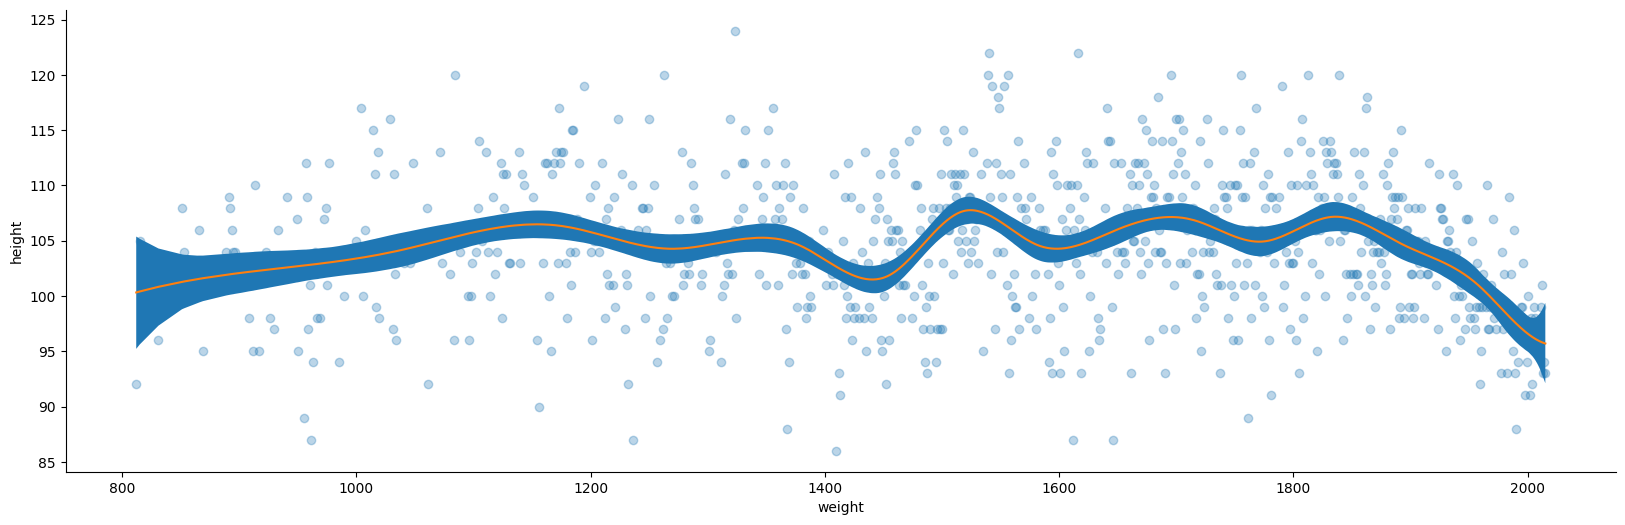

In [75]:
def link(posterior, seq):
    post = posterior.rvs(size=10_000)
    weights_seq = np.tile(seq, (10_000, 1))
    mu = post[:, 0:1] + np.dot(post[:, 1:-1], seq[:, :].T)
    return mu

mu = link(posterior4_7, B);
mu_mean = mu.mean(axis=0)
mu_pi = np.array([np.quantile(m, [0.055, 0.945]) for m in mu.T])

_, ax = plt.subplots(figsize=(20, 6))
plt.plot(d2['year'], d2['doy'], 'o', alpha=0.3)

plt.plot(d2['year'], mu_mean)
plt.fill_between(d2['year'], mu_pi[:, 0], mu_pi[:, 1])

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('weight')
plt.ylabel('height');

### Code 4.79

I will skip this one since I don't think it is needed to show how matrix multiplication works.